In [2]:
import torch
import torch.nn as nn
from nn import LinearBlock, Conv2dBlock, ConvTranspose2dBlock
from torchsummary import summary
import json
import torch.utils.data as data
import h5py
import torchvision.transforms as transforms
from cf_utils import normalize_0_1

In [4]:
# Import Generator and Discriminator (ATTGAN repo). Default values

MAX_DIM = 64 * 16  # 1024
image_size = 384

class Generator(nn.Module):
    def __init__(self, enc_dim=64, enc_layers=5, enc_norm_fn='batchnorm', enc_acti_fn='lrelu',
                 dec_dim=64, dec_layers=5, dec_norm_fn='batchnorm', dec_acti_fn='relu',
                 n_attrs=13, shortcut_layers=1, inject_layers=0, img_size=image_size):
        super(Generator, self).__init__()
        self.shortcut_layers = min(shortcut_layers, dec_layers - 1)
        self.inject_layers = min(inject_layers, dec_layers - 1)
        self.f_size = img_size // 2**enc_layers  # f_size = 4 for 128x128
        
        layers = []
        n_in = 3
        for i in range(enc_layers):
            n_out = min(enc_dim * 2**i, MAX_DIM)
            layers += [Conv2dBlock(
                n_in, n_out, (4, 4), stride=2, padding=1, norm_fn=enc_norm_fn, acti_fn=enc_acti_fn
            )]
            n_in = n_out
        self.enc_layers = nn.ModuleList(layers)
        
        layers = []
        n_in = n_in + n_attrs  # 1024 + 13
        for i in range(dec_layers):
            if i < dec_layers - 1:
                n_out = min(dec_dim * 2**(dec_layers-i-1), MAX_DIM)
                layers += [ConvTranspose2dBlock(
                    n_in, n_out, (4, 4), stride=2, padding=1, norm_fn=dec_norm_fn, acti_fn=dec_acti_fn
                )]
                n_in = n_out
                n_in = n_in + n_in//2 if self.shortcut_layers > i else n_in
                n_in = n_in + n_attrs if self.inject_layers > i else n_in
            else:
                layers += [ConvTranspose2dBlock(
                    n_in, 3, (4, 4), stride=2, padding=1, norm_fn='none', acti_fn='tanh'
                )]
        self.dec_layers = nn.ModuleList(layers)
    
    def encode(self, x):
        z = x
        zs = []
        for layer in self.enc_layers:
            z = layer(z)
            zs.append(z)
        return zs
    
    def decode(self, zs, a):
        a_tile = a.view(a.size(0), -1, 1, 1).repeat(1, 1, self.f_size, self.f_size)
        z = torch.cat([zs[-1], a_tile], dim=1)
        for i, layer in enumerate(self.dec_layers):
            z = layer(z)
            if self.shortcut_layers > i:  # Concat 1024 with 512
                z = torch.cat([z, zs[len(self.dec_layers) - 2 - i]], dim=1)
            if self.inject_layers > i:
                a_tile = a.view(a.size(0), -1, 1, 1) \
                          .repeat(1, 1, self.f_size * 2**(i+1), self.f_size * 2**(i+1))
                z = torch.cat([z, a_tile], dim=1)
        return z
    
    def forward(self, x, a=None, mode='enc-dec'):
        if mode == 'enc-dec':
            assert a is not None, 'No given attribute.'
            return self.decode(self.encode(x), a)
        if mode == 'enc':
            return self.encode(x)
        if mode == 'dec':
            assert a is not None, 'No given attribute.'
            return self.decode(x, a)
        raise Exception('Unrecognized mode: ' + mode)
    
class Discriminators(nn.Module):
    # No instancenorm in fcs in source code, which is different from paper.
    def __init__(self, dim=64, norm_fn='instancenorm', acti_fn='lrelu',
                 fc_dim=1024, fc_norm_fn='none', fc_acti_fn='lrelu', n_layers=5, img_size=image_size):
        super(Discriminators, self).__init__()
        self.f_size = img_size // 2**n_layers
        
        layers = []
        n_in = 3
        for i in range(n_layers):
            n_out = min(dim * 2**i, MAX_DIM)
            layers += [Conv2dBlock(
                n_in, n_out, (4, 4), stride=2, padding=1, norm_fn=norm_fn, acti_fn=acti_fn
            )]
            n_in = n_out
        self.conv = nn.Sequential(*layers)
        self.fc_adv = nn.Sequential(
            LinearBlock(1024 * self.f_size * self.f_size, fc_dim, fc_norm_fn, fc_acti_fn),
            LinearBlock(fc_dim, 1, 'none', 'none')
        )
        self.fc_cls = nn.Sequential(
            LinearBlock(1024 * self.f_size * self.f_size, fc_dim, fc_norm_fn, fc_acti_fn),
            LinearBlock(fc_dim, 13, 'none', 'none')
        )
    
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_adv(h), self.fc_cls(h)

In [5]:
# Instantiate AttGAN class, from ATTGAN repo

class AttGAN():
    def __init__(self, args):
        """Args is a dictionary loaded from the setting.txt file"""
    
        self.enc_dim = args.get('enc_dim')
        self.enc_layers = args.get('enc_layers')
        self.enc_norm = args.get('enc_norm')
        self.enc_acti = args.get('enc_acti')
        self.dec_dim = args.get('dec_dim')
        self.dec_layers = args.get('dec_layers')
        self.dec_norm = args.get('dec_norm')
        self.dect_acti = args.get('dect_acti')
        self.n_attrs = args.get('n_attrs')
        self.shortcut_layers = args.get('shortcut_layers')
        self.inject_layers = args.get('inject_layers')
        self.img_size = args.get('img_size')
        self.dis_dim = args.get('dis_dim')
        self.dis_norm = args.get('dis_norm')
        self.dis_acti = args.get('dis_acti')
        self.dis_fc_dim = args.get('dis_fc_dim')
        self.dis_fc_norm = args.get('dis_fc_norm')
        self.dis_fc_acti = args.get('dis_fc_acti')
        self.dis_layers = args.get('dis_layers')
        
        self.G = Generator(
            self.enc_dim, self.enc_layers, self.enc_norm, self.enc_acti,
            self.dec_dim, self.dec_layers, self.dec_norm, self.dect_acti,
            self.n_attrs, self.shortcut_layers, self.inject_layers, self.img_size
        )
        
        self.D = Discriminators(
            self.dis_dim, self.dis_norm, self.dis_acti,
            self.dis_fc_dim, self.dis_fc_norm, self.dis_fc_acti, self.dis_layers, self.img_size
        )
        
    def eval(self):
        self.G.eval()
        self.D.eval()
        
    def load(self, path):
        states = torch.load(path, map_location=lambda storage, loc: storage)
        if 'G' in states:
            self.G.load_state_dict(states['G'])
        if 'D' in states:
            self.D.load_state_dict(states['D'])
        if 'optim_G' in states:
            self.optim_G.load_state_dict(states['optim_G'])
        if 'optim_D' in states:
            self.optim_D.load_state_dict(states['optim_D'])

In [6]:
# Load settings

with open('./384_shortcut1_inject1_none_hq/setting.txt', 'r') as f:
    gan_args = json.load(f)

In [7]:
# Load dataloader ATTGAN repo

from data import Custom
test_dataset = Custom('./data/custom', './data/list_attr_custom.txt', gan_args.get('img_size'), gan_args.get('attrs'))
test_dataloader = data.DataLoader(
    test_dataset, batch_size=1, num_workers=gan_args.get('num_workers'),
    shuffle=False, drop_last=False
)
# Normalizes data using mean 0.5 and std 0.5 -> range [-1, 1]

# Test Data
imgs = []
atts = []
for idx, (img_a, att_a) in enumerate(test_dataloader):
  imgs.append(img_a), 
  atts.append(att_a)
  
# Receives PIL Image (384, 384, 3) x (0, 255)
# To Tensor scales to (0, 1)
# Normalize scales to (-1, 1) [(0 - 0.5)/0.5, (1 - 0.5)/0.5]
# Outputs tensor (1, 3, 384, 384) x (-1, 1)

In [8]:
# ATTGAN repo

def check_attribute_conflict(att_batch, att_name, att_names):
    def _get(att, att_name):
        if att_name in att_names:
            return att[att_names.index(att_name)]
        return None
    def _set(att, value, att_name):
        if att_name in att_names:
            att[att_names.index(att_name)] = value
    att_id = att_names.index(att_name)
    for att in att_batch:
        if att_name in ['Bald', 'Receding_Hairline'] and att[att_id] != 0:
            if _get(att, 'Bangs') != 0:
                _set(att, 1-att[att_id], 'Bangs')
        elif att_name == 'Bangs' and att[att_id] != 0:
            for n in ['Bald', 'Receding_Hairline']:
                if _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
                    _set(att, 1-att[att_id], n)
        elif att_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair'] and att[att_id] != 0:
            for n in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                if n != att_name and _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
        elif att_name in ['Straight_Hair', 'Wavy_Hair'] and att[att_id] != 0:
            for n in ['Straight_Hair', 'Wavy_Hair']:
                if n != att_name and _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
        elif att_name in ['Mustache', 'No_Beard'] and att[att_id] != 0:
            for n in ['Mustache', 'No_Beard']:
                if n != att_name and _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
    return att_batch

In [9]:
# Load AttGAN

attgan = AttGAN(gan_args)
attgan.load('./384_shortcut1_inject1_none_hq/weights.149.pth')
attgan.eval()

In [ ]:
# Import the h5 file directly

model_path = './classifier_model.h5'

with h5py.File(model_path, 'r') as f:
    if 'model_config' in f.attrs:
        model_config_str = f.attrs['model_config']  # no decode needed
        model_config = json.loads(model_config_str)
        print(json.dumps(model_config, indent=2))  # Pretty print
    else:
        print("No model_config found in HDF5 file.")

In [11]:
# Model structure
# Input (N, 128, 128, 3) 
# CONV1 (3, 16, 3, 3). stride = 1, padding = valid, dilation_rate [1, 1] + ReLU. Includes bias. 
# Dropout 0.9
# CONV2 (16, 4, 3, 3), stride = 1, padding = valid, dilation_rate [1, 1] + ReLU
# Flatten - Dense Layer. Sigmoid activation with 1 unit.
#['conv2d_1', 'conv2d_2', 'dense_1', 'dropout_1', 'flatten_1']

with h5py.File('./classifier_model.h5', 'r') as f:
    conv1_w = f['model_weights']['conv2d_1']['conv2d_1']['kernel:0'][()] # 16 filters, 3 kernels, 1 stride, padding valid, dilation rate [1, 1]
    conv1_b = f['model_weights']['conv2d_1']['conv2d_1']['bias:0'][()] #
    conv2_w = f['model_weights']['conv2d_2']['conv2d_2']['kernel:0'][()] #
    conv2_b = f['model_weights']['conv2d_2']['conv2d_2']['bias:0'][()] # 
    dense_1_w = f['model_weights']['dense_1']['dense_1']['kernel:0'][()] #
    dense_1_b = f['model_weights']['dense_1']['dense_1']['bias:0'][()] # 

In [12]:
# Pytorch recreated - classifier

class GenderClassifier(nn.Module):
  def __init__(self)  :
      super(GenderClassifier, self).__init__()
            
      self.cnn_module = nn.Sequential(
                          nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1), 
                          nn.Dropout(0.9),
                          nn.ReLU(),
                          nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = 3, stride = 1),
                          nn.ReLU()
                        )   
      
      self.flatten = nn.Flatten()
      
      self.fc = nn.Sequential(
                  nn.Linear(61504, 1),
                  nn.Sigmoid()
                )
      
      self.resize = transforms.Resize(128)
      
  def forward(self, x):
    if x.shape[2] or x.shape[3] > 128:
      x = self.resize(x)
    cnn_output = self.cnn_module(x)
    flattened_features = self.flatten(cnn_output)
    scores = self.fc(flattened_features)
    return scores

In [13]:
# Instanciate the classifier and load the weights from COUNT-GEN repo

gender_classifier = GenderClassifier()
with torch.no_grad():
  gender_classifier.cnn_module[0].weight.data = torch.from_numpy(conv1_w).permute(3, 2, 0, 1)
  gender_classifier.cnn_module[0].bias.data = torch.from_numpy(conv1_b)
  gender_classifier.cnn_module[3].weight.data = torch.from_numpy(conv2_w).permute(3, 2, 0, 1)
  gender_classifier.cnn_module[3].bias.data = torch.from_numpy(conv2_b)
  gender_classifier.fc[0].weight.data = torch.from_numpy(dense_1_w).permute(1, 0)
  gender_classifier.fc[0].bias.data = torch.from_numpy(dense_1_b)

In [14]:
# MiVOLO Classifier 

import argparse
import logging
import os
import sys
import ultralytics
import cv2
import torch
import yt_dlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics.utils.plotting import colors

# Scripts
from mivolo.data.data_reader import InputType, get_all_files, get_input_type
from mivolo.predictor import Predictor
from timm.utils import setup_default_logging

_logger = logging.getLogger("inference")

# Helper function
def get_parser():
    parser = argparse.ArgumentParser(description="PyTorch MiVOLO Inference")
    parser.add_argument("--input", type=str, default=None, required=True, help="image file or folder with images")
    parser.add_argument("--output", type=str, default=None, required=True, help="folder for output results")
    parser.add_argument("--detector-weights", type=str, default=None, required=True, help="Detector weights (YOLOv8).")
    parser.add_argument("--checkpoint", default="", type=str, required=True, help="path to mivolo checkpoint")

    parser.add_argument(
        "--with-persons", action="store_true", default=False, help="If set model will run with persons, if available"
    )
    parser.add_argument(
        "--disable-faces", action="store_true", default=False, help="If set model will use only persons if available"
    )

    parser.add_argument("--draw", action="store_true", default=False, help="If set, resulted images will be drawn")
    parser.add_argument("--device", default="cuda", type=str, help="Device (accelerator) to use.")

    return parser

detector_weights = "./mivolo_models/yolov8x_person_face.pt"
checkpoint =  "./mivolo_models/model_imdb_cross_person_4.22_99.46.pth.tar"
device = "cpu"
input = "/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY/data/custom" 

parser = get_parser()
args = parser.parse_args(
    [
        "--input",f"""{input}""", 
        "--detector-weights", f"""{detector_weights}""", 
        "--checkpoint", f"""{checkpoint}""", 
        "--device", f"""{device}""",
        "--output", 'output',
        "--with-persons",
        "--draw"
        
    ]
)

predictor = Predictor(args, verbose=True)

Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


In [15]:
# miVOLO helper function

def mivolo_inference(cv2_img, return_age = False):
  detected_objects, out_im = predictor.recognize(cv2_img)
  if detected_objects.n_faces != 0:
    gender_string = detected_objects.genders[0]
    mivolo_gender_score = detected_objects.gender_scores[0]
    age = detected_objects.ages[0]
    if gender_string == "male":
      mivolo_gender_prob = 1 - mivolo_gender_score
    elif gender_string == "female":
      mivolo_gender_prob = mivolo_gender_score
  else:
    mivolo_gender_prob = np.inf
    age = np.inf
  if return_age:
    return mivolo_gender_prob, age
  else:
    return mivolo_gender_prob


0: 640x640 1 person, 1 face, 1234.8ms
Speed: 16.8ms preprocess, 1234.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 face, 418.6ms
Speed: 1.5ms preprocess, 418.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Text(0.1, 0.01, "Input attributes: ['Brown_Hair', 'Male', 'Young']\nModified attributes: [('Blond_Hair', 0.8999999761581421), ('Male', -1.0), ('Mouth_Slightly_Open', 0.800000011920929), ('No_Beard', 1.0), ('Young', 0.800000011920929)]\nReal Disc Score 0.138\nFake Disc Score 0.141\nGender Probability Factual 0.002784\nGender Probability CF 0.997114")

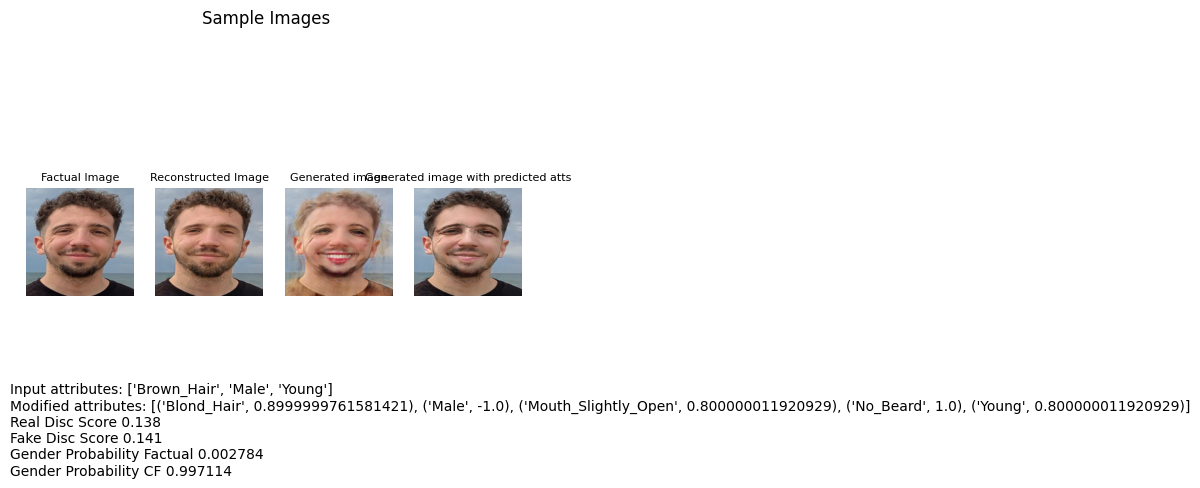

In [36]:
# Generate changes over a image

# arab ariel ['Black_Hair', 'Mustache', 'Bushy_Eyebrows']
# "Bald", "Bangs", "Black_Hair", "Blond_Hair", "Brown_Hair", "Bushy_Eyebrows","Eyeglasses", "Male", "Mouth_Slightly_Open",  "Mustache", "No_Beard", "Pale_Skin", "Young"
# Removed male

test_atts = ['Male', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'Blond_Hair']
test_ints = [1, 1, 0.8, -0.8, 0.9] # Multiplica!!!. Si el atributo existía queda -1 x test_int, si el atributo no existía queda 1 x test_int
custom_img = True
base_attrs = gan_args.get('attrs')
thres_int = 0.5 # Este valor mide la intensidad del cambio.

sample_idx = 2

img_a = test_dataset[sample_idx][0].unsqueeze(0) # Add batch dimension
att_a = test_dataset[sample_idx][1].unsqueeze(0) # Add batch dimension
    
att_a = att_a.type(torch.float)
att_b = att_a.clone()

for a in test_atts:
  i = base_attrs.index(a)
  att_b[:, i] = 1 - att_b[:, i] # El atributo en el listado de test, lo invierte. Si estaba ahora pasa a ser 0, si no estaba pasa a ser 1.
  att_b = check_attribute_conflict(att_b, base_attrs[i], base_attrs) 

with torch.no_grad():
  att_b_ = (att_b * 2 - 1) * thres_int # Lleva al rango [-1, 1] * test intensity = [-0.5, 0.5]. Si estaba ahora es -1, si no estaba es 1
  att_rec = (att_a * 2 - 1) * thres_int 
  for a, i in zip(test_atts, test_ints):
    att_b_[..., base_attrs.index(a)] = att_b_[..., base_attrs.index(a)] * i / thres_int # Reescala para representar la intensidad del attributo presente
    # Aplica la intensidad multiplicando por el valor seleccionado
  img_fake = attgan.G(img_a, att_b_)
  img_rec = attgan.G(img_a, att_rec)
  d_fake, dc_fake = attgan.D(img_fake)
  d_real, dc_real = attgan.D(img_a)
  img_rec_pred_atts = attgan.G(img_a, dc_real)
  modified_indices = ((att_b_ != -torch.tensor(0.5)) * (att_b_ != -torch.tensor(0))).squeeze(0).nonzero()
  modified_atts = [(base_attrs[i], att_b_[:, i].item()) for i in modified_indices]
  
img_factual = normalize_0_1(img_a).squeeze(0).permute(1, 2, 0).numpy()
img_cfactual = normalize_0_1(img_fake, fake = True).squeeze(0).permute(1, 2, 0).numpy()
img_reconst = normalize_0_1(img_rec, fake = True).squeeze(0).permute(1, 2, 0).numpy()
img_reconst_pred_atts = normalize_0_1(img_rec_pred_atts, fake = True).squeeze(0).permute(1, 2, 0).numpy()

img_cfactual_for_pred = (img_cfactual * 255).astype(np.uint8)
img_factual_for_pred = (img_factual * 255).astype(np.uint8)
cv2_img_f_sample = cv2.cvtColor(img_factual_for_pred, cv2.COLOR_RGB2BGR)
cv2_img_cf_sample = cv2.cvtColor(img_cfactual_for_pred, cv2.COLOR_RGB2BGR)
new_pred_cf_sample, _ = mivolo_inference(cv2_img_cf_sample, True)
new_pred_f_sample, _ = mivolo_inference(cv2_img_f_sample, True)

%matplotlib inline
att_list = [att for att, flag in zip(base_attrs, atts[sample_idx].tolist()[0]) if flag == 1]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(img_factual)
ax2.imshow(img_reconst)
ax3.imshow(img_cfactual)
ax4.imshow(img_reconst_pred_atts)
ax1.title.set_text('Factual Image')
ax1.title.set_fontsize(8)  
ax2.title.set_text('Reconstructed Image')
ax2.title.set_fontsize(8) 
ax3.title.set_text('Generated image')
ax3.title.set_fontsize(8) 
ax4.title.set_text('Generated image with predicted atts')
ax4.title.set_fontsize(8) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.suptitle('Sample Images')
plt.figtext(0.10, 0.01, f"""Input attributes: {att_list}\nModified attributes: {modified_atts}\nReal Disc Score {round(d_real.item(), 3)}\nFake Disc Score {round(d_fake.item(), 3)}\nGender Probability Factual {round(new_pred_f_sample, 6)}\nGender Probability CF {round(new_pred_cf_sample, 6)}""")


0: 640x640 1 person, 1 face, 345.7ms
Speed: 3.5ms preprocess, 345.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Text(0.2, -0.05, "Input attributes: ['Brown_Hair', 'Young']\nCOUNT-GEN Gender score: 0.017245056107640266\nMiVolo Gender score: 0.9971235394477844\nMiVolo Age: 32.91")

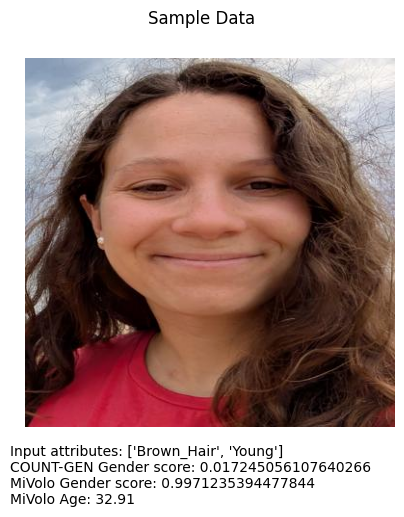

In [25]:
# Test the classifiers

gender_classifier.eval()

%matplotlib inline
sample_idx = 3
base_img = normalize_0_1(imgs[sample_idx])
img = base_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img = (img * 255).astype(np.uint8)
cv2_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
att_list = [att for att, flag in zip(base_attrs, atts[sample_idx].tolist()[0]) if flag == 1]
plt.imshow(img)
plt.suptitle('Sample Data')
plt.axis('off')
gender_score = gender_classifier(base_img).item()
mivolo_gender_prob, age = mivolo_inference(cv2_img, True)
plt.figtext(0.2, -0.05, f"""Input attributes: {att_list}\nCOUNT-GEN Gender score: {gender_score}\nMiVolo Gender score: {mivolo_gender_prob}\nMiVolo Age: {age}""")